In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel, BertTokenizer, BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load Pretrained Models and Tokenizer from Hugging Face
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Kaggle File Paths - Adjust according to your dataset
DATA_PATH = "/kaggle/input/memotion-dataset-7k/memotion_dataset_7k"  # Adjust if needed
CSV_PATH = os.path.join(DATA_PATH, "labels.csv")
IMAGE_PATH = os.path.join(DATA_PATH, "images/")

In [6]:
df = pd.read_csv(CSV_PATH)

# Iterate over the DataFrame and check for missing images
missing_images = []

for idx, row in df.iterrows():
    image_name = row["image_name"]  # Replace with the exact column name in your DataFrame
    image_path = os.path.join(IMAGE_PATH, image_name)

    # Attempt to read the image
    image = cv2.imread(image_path)
    
    if image is None:  # Image is either missing or unreadable
        print(f"Invalid or missing image: {image_path}")
        missing_images.append(image_name)
    else:
        # Check for warnings (this part may require manual handling if warnings affect image validity)
        # Example: you might want to treat certain warnings as invalid images.
        try:
            # This is just a placeholder to illustrate that we can check conditions for warnings.
            # In practice, check the image data itself or use other libraries to validate.
            # For example, if the image has a specific shape or type that indicates it's invalid.
            if image.shape[0] == 0 or image.shape[1] == 0:  # Placeholder check
                print(f"Invalid image shape: {image_path}")
                missing_images.append(image_name)
        except Exception as e:
            print(f"Error processing image: {image_path}, Error: {str(e)}")
            missing_images.append(image_name)

# Filter out rows with missing images
df_cleaned = df[~df["image_name"].isin(missing_images)]

# Save the cleaned DataFrame if needed
# df_cleaned.to_csv("cleaned_dataset.csv", index=False)

print(f"Original Records: {len(df)}")
print(f"\nTotal Invalid or Missing Images: {len(missing_images)}")
print(f"Remaining Records: {len(df_cleaned)}")

libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG


Invalid or missing image: /kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images/image_1567.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Invalid or missing image: /kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images/image_4924.jpg
Invalid or missing image: /kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images/image_5119.png


libpng error: Read Error
libpng warning: iCCP: known incorrect sRGB profile


Invalid or missing image: /kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images/image_6357.jpg


libpng warning: iCCP: known incorrect sRGB profile


Original Records: 6992

Total Invalid or Missing Images: 4
Remaining Records: 6988


In [7]:
df_cleaned.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [8]:
df_cleaned['overall_sentiment'].value_counts()

overall_sentiment
positive         3124
neutral          2201
very_positive    1032
negative          480
very_negative     151
Name: count, dtype: int64

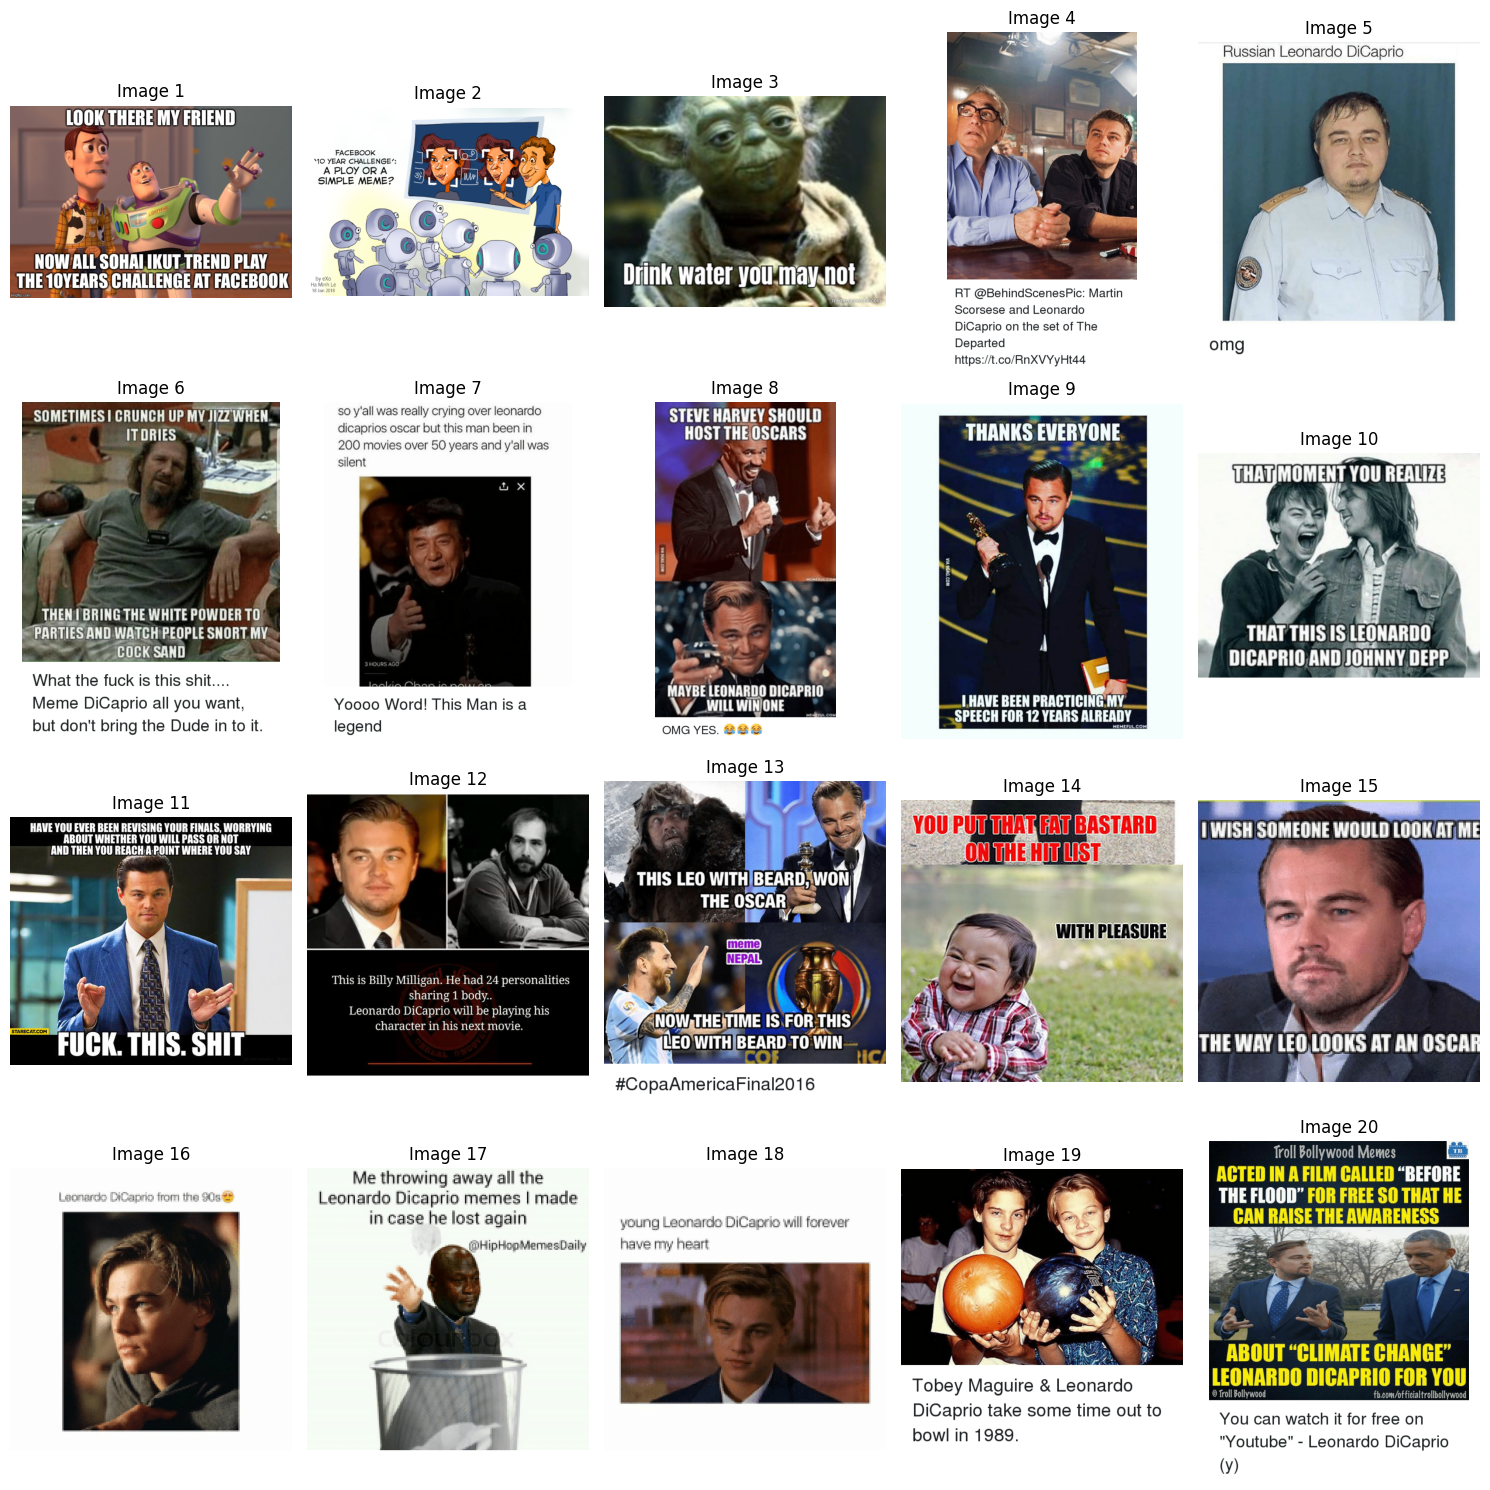

In [9]:
# List all image files in the directory
image_files = sorted(os.listdir(IMAGE_PATH))  # Sort to ensure consistent order

# Plot the first 20 images
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed

for i, image_file in enumerate(image_files[:20]):  # Loop through the first 20 images
    image_path = os.path.join(IMAGE_PATH, image_file)
    image = Image.open(image_path)  # Open the image
    
    # Display each image in a grid
    plt.subplot(4, 5, i + 1)  # Create a 4x5 grid
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Image {i+1}")  # Optional: Add title to each image

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import os
import cv2
import torch
from sklearn.preprocessing import LabelEncoder

class MemotionDataset(Dataset):
    def __init__(self, dataframe, image_folder):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.clip_processor = clip_processor
        self.bert_tokenizer = bert_tokenizer
        
        # Encode categorical columns
        self.label_encoders = {}
        for column in ['humour', 'sarcasm', 'offensive', 'motivational','overall_sentiment']:
            le = LabelEncoder()
            self.dataframe[column] = le.fit_transform(self.dataframe[column])
            self.label_encoders[column] = le

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        image = cv2.imread(image_path)
        
        # Ensure the image was loaded successfully
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with CLIP
        clip_inputs = self.clip_processor(images=image, return_tensors="pt")
        
        text = str(row["text_corrected"])
        text_inputs = self.bert_tokenizer(
            text, return_tensors="pt", padding="max_length", max_length=32, truncation=True
        )
        
        # Convert labels to tensors
        label = torch.tensor(row["overall_sentiment"], dtype=torch.long)
        humour = torch.tensor(row["humour"], dtype=torch.long)  # Use long for encoded categories
        sarcasm = torch.tensor(row["sarcasm"], dtype=torch.long)
        offensive = torch.tensor(row["offensive"], dtype=torch.long)
        motivational = torch.tensor(row["motivational"], dtype=torch.long)

        return clip_inputs, text_inputs, label, humour, sarcasm, offensive, motivational

    def __len__(self):
        return len(self.dataframe)


In [11]:
# Custom Collate Function to Handle Batch Padding
def collate_fn(batch):
    # Handling CLIP inputs
    clip_inputs = {
        key: torch.cat([item[0][key] for item in batch], dim=0)
        for key in batch[0][0]
    }
    
    # Handling BERT inputs
    text_inputs = {
        key: torch.cat([item[1][key] for item in batch], dim=0)
        for key in batch[0][1]
    }
    
    # Stacking labels and additional features
    labels = torch.stack([item[2] for item in batch])
    humour = torch.stack([item[3] for item in batch])
    sarcasm = torch.stack([item[4] for item in batch])
    offensive = torch.stack([item[5] for item in batch])
    motivational = torch.stack([item[6] for item in batch])
    
    return clip_inputs, text_inputs, labels, humour, sarcasm, offensive, motivational


In [12]:
# DataLoader with Collate Function

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Define the split ratio (80% training, 20% testing)
train_indices, test_indices = train_test_split(
    range(len(df_cleaned)), test_size=0.2, random_state=42
)

# Create Subsets for Train and Test Data
train_dataset = Subset(MemotionDataset(df_cleaned, IMAGE_PATH), train_indices)
test_dataset = Subset(MemotionDataset(df_cleaned, IMAGE_PATH), test_indices)

# Define DataLoaders for Train and Test Data
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")


Train samples: 5590, Test samples: 1398


/tmp/ipykernel_30/3249299173.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[column] = le.fit_transform(self.dataframe[column])
/tmp/ipykernel_30/3249299173.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[column] = le.fit_transform(self.dataframe[column])
/tmp/ipykernel_30/3249299173.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [13]:
# Define the Multimodal Sentiment Model
class MultimodalSentimentModel(torch.nn.Module):
    def __init__(self):
        super(MultimodalSentimentModel, self).__init__()
        self.clip_model = clip_model.vision_model  # Use only the vision part of CLIP
        self.bert_model = bert_model
        
        # Assuming we have 4 additional features
        self.fc = torch.nn.Linear(1540, 5)  # 1536 from image and text + 4 additional features

    def forward(self, clip_inputs, text_inputs, humour, sarcasm, offensive, motivational):
        # Extract image features using CLIP
        image_features = self.clip_model(pixel_values=clip_inputs["pixel_values"]).pooler_output

        # Extract text features using BERT
        text_features = self.bert_model(
            input_ids=text_inputs["input_ids"],
            attention_mask=text_inputs["attention_mask"]
        ).pooler_output

        # Concatenate all features
        combined_features = torch.cat((image_features, text_features, humour.unsqueeze(1), sarcasm.unsqueeze(1), offensive.unsqueeze(1), motivational.unsqueeze(1)), dim=1)

        # Pass through the fully connected layer for classification
        output = self.fc(combined_features)
        return output


In [14]:
# Initialize Model, Loss Function, and Optimizer
class_counts = df_cleaned["overall_sentiment"].value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = class_weights.to_numpy()
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = MultimodalSentimentModel().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training Function
train_losses = []
test_losses = []
def train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for clip_inputs, text_inputs, labels, humour, sarcasm, offensive, motivational in train_dataloader:
            # Send inputs and labels to GPU (if available)
            clip_inputs = {k: v.to(device) for k, v in clip_inputs.items()}
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            labels = labels.to(device)
            humour = humour.to(device)
            sarcasm = sarcasm.to(device)
            offensive = offensive.to(device)
            motivational = motivational.to(device)

            optimizer.zero_grad()
            outputs = model(clip_inputs, text_inputs, humour, sarcasm, offensive, motivational)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss/ len(train_dataloader))
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader):.4f}")
        with torch.no_grad():
            for clip_inputs, text_inputs, labels, humour, sarcasm, offensive, motivational in test_dataloader:
                clip_inputs = {k: v.to(device) for k, v in clip_inputs.items()}
                text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
                labels = labels.to(device)
                humour = humour.to(device)
                sarcasm = sarcasm.to(device)
                offensive = offensive.to(device)
                motivational = motivational.to(device)

                outputs = model(clip_inputs, text_inputs, humour, sarcasm, offensive, motivational)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        


In [16]:
all_preds = []
all_labels = []
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()

    with torch.no_grad():
        for clip_inputs, text_inputs, labels, humour, sarcasm, offensive, motivational in dataloader:
            clip_inputs = {k: v.to(device) for k, v in clip_inputs.items()}
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            labels = labels.to(device)
            humour = humour.to(device)
            sarcasm = sarcasm.to(device)
            offensive = offensive.to(device)
            motivational = motivational.to(device)

            outputs = model(clip_inputs, text_inputs, humour, sarcasm, offensive, motivational)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds))

In [17]:
# Train the Model
print("Starting Training...")
train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=20)

Starting Training...


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 1, Loss: 1.8812


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 2, Loss: 1.7843


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 3, Loss: 1.7143


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 4, Loss: 1.7114


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 5, Loss: 1.6794


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 6, Loss: 1.6702


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 7, Loss: 1.5895


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 8, Loss: 1.5523


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 9, Loss: 1.5524


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 10, Loss: 1.5479


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 11, Loss: 1.5523


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 12, Loss: 1.5454


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 13, Loss: 1.5472


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 14, Loss: 1.5513


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 15, Loss: 1.5520


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 16, Loss: 1.5459


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch 17, Loss: 1.5439


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile


Epoch 18, Loss: 1.5420


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 19, Loss: 1.5411


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Epoch 20, Loss: 1.5463


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG


In [18]:
train_losses

[1.8811635829518965,
 1.7843215063065077,
 1.7142592497137994,
 1.7114284539938995,
 1.6793547560899214,
 1.670219787968075,
 1.5894914155183772,
 1.5523145183473186,
 1.5523747424881515,
 1.5478769402647223,
 1.552276126816549,
 1.545428771999943,
 1.5472326009229187,
 1.5512716500714783,
 1.5520085687289422,
 1.5459168528623677,
 1.5438910610174417,
 1.5419747621375262,
 1.5410646343435852,
 1.546251941648164]

In [19]:
test_losses

[3.699314594268799,
 3.9424264430999756,
 2.9088332653045654,
 3.121049165725708,
 1.4013758897781372,
 1.389589786529541,
 1.7948899269104004,
 2.0266189575195312,
 2.087074041366577,
 2.069979667663574,
 1.8134335279464722,
 2.0208733081817627,
 2.080350160598755,
 2.114840269088745,
 1.9285950660705566,
 1.9739372730255127,
 1.882037878036499,
 1.8475840091705322,
 1.895490288734436,
 1.9775099754333496]

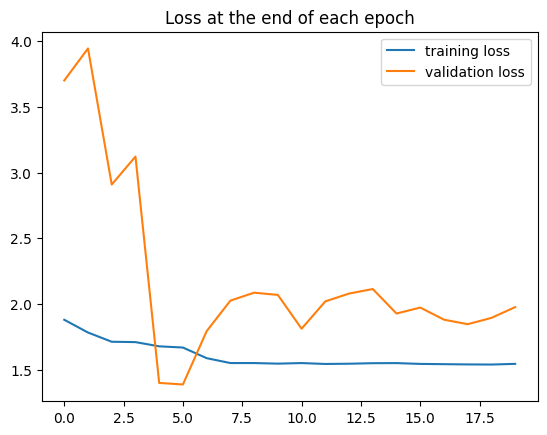

In [20]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [21]:
print("Starting Testing...")
evaluate(model, test_dataloader)

Starting Testing...


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG


Accuracy: 0.2989985693848355
              precision    recall  f1-score   support

           0       0.14      0.11      0.12       100
           1       0.40      0.41      0.40       448
           2       0.46      0.21      0.29       614
           3       0.00      0.00      0.00        34
           4       0.17      0.48      0.25       202

    accuracy                           0.30      1398
   macro avg       0.23      0.24      0.21      1398
weighted avg       0.36      0.30      0.30      1398



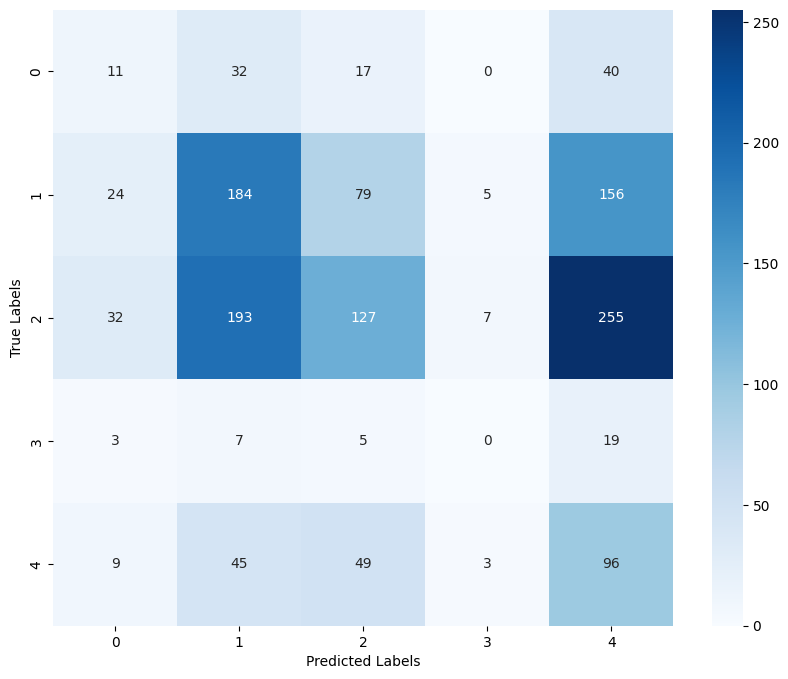

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
import random

# Ensure the model is in evaluation mode
model.eval()

# Step 1: Get a random batch from the DataLoader
batch = next(iter(test_dataloader))  # Extract a batch

# Step 2: Pick a random index within the batch
batch_size = batch[0]["pixel_values"].size(0)  # Get the batch size
random_idx = random.randint(0, batch_size - 1)  # Random index

# Step 3: Extract inputs and labels for the random sample
clip_inputs = {k: v[random_idx].unsqueeze(0).to(device) for k, v in batch[0].items()}
text_inputs = {k: v[random_idx].unsqueeze(0).to(device) for k, v in batch[1].items()}
label = batch[2][random_idx].unsqueeze(0).to(device)
humour = batch[3][random_idx].unsqueeze(0).to(device)
sarcasm = batch[4][random_idx].unsqueeze(0).to(device)
offensive = batch[5][random_idx].unsqueeze(0).to(device)
motivational = batch[6][random_idx].unsqueeze(0).to(device)

# Step 4: Make a prediction with the model
with torch.no_grad():
    output = model(clip_inputs, text_inputs, humour, sarcasm, offensive, motivational)

# Step 5: Get the predicted class index
predicted_class_idx = torch.argmax(output, dim=1).item()

# Step 6: Access the original dataset from the Subset object
original_dataset = test_dataset.dataset  # Extract the original dataset

# Step 7: Decode both the predicted and true labels
predicted_class = original_dataset.label_encoders["overall_sentiment"].inverse_transform(
    [predicted_class_idx]
)[0]
true_class = original_dataset.label_encoders["overall_sentiment"].inverse_transform(
    [label.item()]
)[0]

# Step 8: Print the results
print(f"True Class: {true_class}")
print(f"Predicted Class: {predicted_class}")


True Class: 1
Predicted Class: 1


In [24]:
torch.save(model.state_dict(),'MultiModel_Sentiment_Analysis_Model.pt')